In [16]:
# Load segmentation mask
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import h5py
import torch
print(os.getpid())
plt.style.use('dark_background')


43455


In [2]:
# ChromAn ris_availabled imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn

from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive
from ChromAn.src.spot_tools.spot_class import Spots3D

In [18]:
# data folder
data_folder = r'/lab/weissman_imaging/puzheng/PE_LT/20230829-zombie-4T1v21x'
# scan subfolders
folders, fovs = data_organization.search_fovs_in_folders(data_folder)
# analysis folder
analysis_folder = os.path.join(data_folder, 'Analysis')
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

- searching in folder: /lab/weissman_imaging/puzheng/PE_LT/20230829-zombie-4T1v21x
-- 8 folders, 68 fovs detected.


In [19]:
# color usage
color_usage_filename = os.path.join(data_folder, 'Analysis', 'Color_Usage.csv')
color_usage_df = data_organization.Color_Usage(color_usage_filename)

- load color_usage from file: /lab/weissman_imaging/puzheng/PE_LT/20230829-zombie-4T1v21x/Analysis/Color_Usage.csv


In [20]:
from ChromAn.src.spot_tools.partition_spots import Spots_Partition
# match spots:
from scipy.spatial.distance import cdist

In [24]:
fov_2_info = {}
for _fov_id, _fov_name in enumerate(fovs):
    _fov_filename = os.path.join(folders[0], fovs[_fov_id])
    _save_filename = _fov_filename.replace('.dax', '.hdf5')

    # load spots, dapi_im and segmentation mask:
    with h5py.File(_save_filename, 'r') as _f:
        _spots_748 = Spots3D(_f['H0M1/748/spots'][:])
        _spots_637 = Spots3D(_f['H0M1/637/spots'][:])
        #_im_748 = _f['H0M1/748/im'][:]
        #_im_637 = _f['H0M1/637/im'][:]
        #_dapi_im = _f['H0M1/405/im'][:]
        _dna_mask = _f['dapi_mask'][:]
        #print(_f['.'].keys())

    allowed_drift_th = 5
    dists =  1 / cdist(_spots_748.to_coords(), _spots_637.to_coords())
    x_coords, y_coords = np.where(dists > 1/allowed_drift_th)
    kept_spots_748, kept_spots_637 = _spots_748[x_coords], _spots_637[y_coords]

    # Search for segmentation label
    _label_748 = Spots_Partition.spots_to_labels(
        _dna_mask, kept_spots_748, 
        search_radius=5, 
        verbose=True,
    )

    # Search for segmentation label
    _label_637 = Spots_Partition.spots_to_labels(
        _dna_mask, _spots_637, #kept_spots_637, 
        search_radius=5, 
        verbose=True,
    )
    num_positive = len(np.unique(_label_748)[np.unique(_label_748) >= 0])
    #num_positive = len(np.unique(_label_637)[np.unique(_label_637) >= 0])
    num_total = np.max(_dna_mask)
    # append
    fov_2_info[_fov_id] = {
        'num_positive': num_positive,
        'num_total': num_total,
    }
    print(_fov_id, num_positive, num_total)


-- partition barcodes for 94 spots
-- partition barcodes for 106 spots
0 63 132
-- partition barcodes for 72 spots
-- partition barcodes for 97 spots
1 44 131
-- partition barcodes for 28 spots
-- partition barcodes for 35 spots
2 22 52
-- partition barcodes for 35 spots
-- partition barcodes for 42 spots
3 27 63
-- partition barcodes for 27 spots
-- partition barcodes for 32 spots
4 16 130
-- partition barcodes for 45 spots
-- partition barcodes for 56 spots
5 28 58
-- partition barcodes for 47 spots
-- partition barcodes for 52 spots
6 44 115
-- partition barcodes for 58 spots
-- partition barcodes for 71 spots
7 42 149
-- partition barcodes for 35 spots
-- partition barcodes for 92 spots
8 22 94
-- partition barcodes for 70 spots
-- partition barcodes for 76 spots
9 45 114
-- partition barcodes for 12 spots
-- partition barcodes for 26 spots
10 10 41
-- partition barcodes for 39 spots
-- partition barcodes for 47 spots
11 34 93
-- partition barcodes for 95 spots
-- partition barcode

In [27]:
# calculate total ratio
total_positive, total_total = 0, 0
for _fov, _info in fov_2_info.items():
    num_positive, num_total = _info['num_positive'], _info['num_total']
    #if num_total == 0 or num_positive == 0:
    #    continue
    total_positive += num_positive
    total_total += num_total
#total_positive = np.sum([_v['num_positive'] for _k, _v in fov_2_info.items()])
#total_total = np.sum([_v['num_total'] for _k, _v in fov_2_info.items()])
print(f"Detection ratio for {os.path.basename(data_folder)}: {total_positive / total_total}")

Detection ratio for 20230829-zombie-4T1v21x: 0.3628415300546448


In [26]:
fov_detection_df = pd.DataFrame.from_dict(fov_2_info, orient='index')
fov_detection_df['fov_id'] = fov_2_info.keys()
fov_detection_df['ratio'] = fov_detection_df['num_positive'] / fov_detection_df['num_total']
fov_detection_df = fov_detection_df.set_index('fov_id')

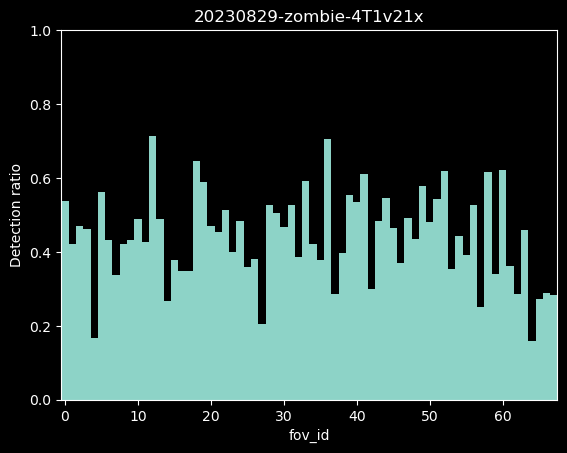

In [17]:
%matplotlib inline
plt.figure()
plt.bar(x=fov_detection_df.index, height=fov_detection_df['ratio'], width=1)
plt.xlabel('fov_id')
plt.ylabel('Detection ratio')
plt.xlim([0-0.5, len(fov_detection_df)-0.5])
plt.ylim([0,1])
plt.title(os.path.basename(data_folder))
plt.show()

In [76]:
np.save

0.21333333333333335

<IPython.core.display.Javascript object>


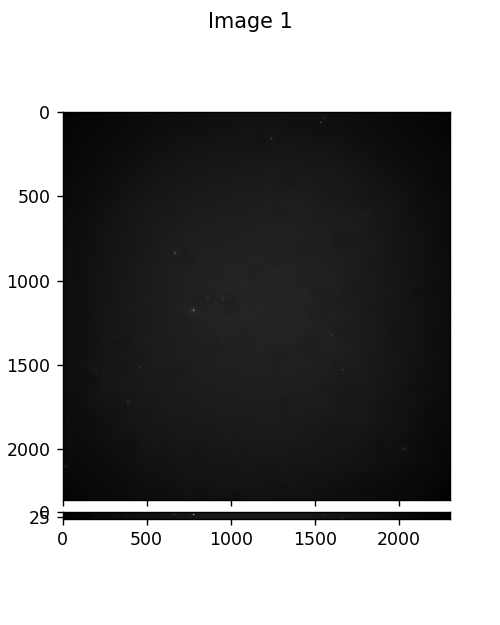

In [64]:
interactive.imshow_mark_3d([_im_748, _im_637])

In [45]:
len(kept_spots_748), len(kept_spots_637)

(33, 33)

<IPython.core.display.Javascript object>


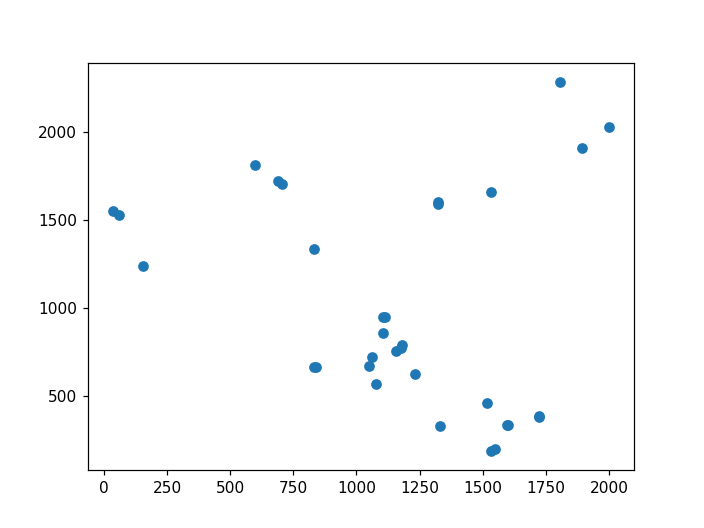

In [46]:
plt.figure()
plt.scatter(kept_spots_637.to_coords()[:,1], kept_spots_637.to_coords()[:,2])

In [47]:
len(np.unique(x_coords))

32

In [48]:
len(x_coords), len(y_coords)

(33, 33)

-- partition barcodes for 73 spots


# find nearest match

In [50]:
len(np.unique(_dna_mask))

76

In [51]:
len(np.unique(_labels))

21

<IPython.core.display.Javascript object>


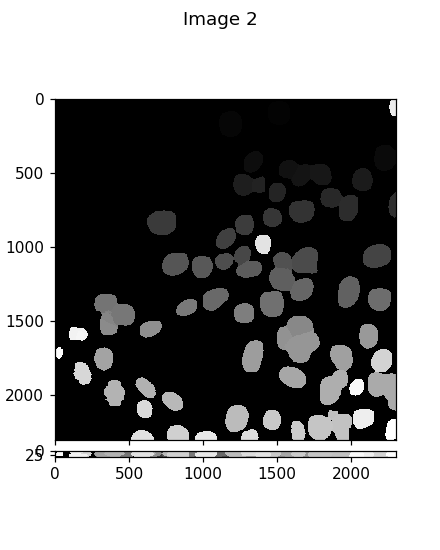

In [52]:
%matplotlib notebook
interactive.imshow_mark_3d([_dapi_im, _dna_mask])